In [19]:
# Load the libraries we will use
suppressPackageStartupMessages(library(tidyverse))

# Set a simple theme
theme_set(theme_classic(base_size = 18))

# Adjust plot size
options(repr.plot.width=15, repr.plot.height=9)

# Set a global value for the number of samples taken for visualisation purposes
sample_n <- 5000

# Reproducibility
set.seed(9382)

# 🌱 Planting Seeds

Imagine planting seeds in a row.

> ⭐ **Key Assumptions:**
> 1. The event of planting a seed does not depend on the previous one.
> 2. The average number of seeds planted in a fixed length (e.g., `1m`) is constant.
> 3. There are no **guides** in place to develop a perfectly spaced row of seeds

All we have is a **marker** for the row enabling us to plant in a straight line.

## Simulating Seed Locations

To simulating the planting of seeds we need to decide on a *strategy*.

> **Distance between seeds**:
> * The distance $d_i$ between two planted seeds follows an exponential distribution with rate `lambda=seeds_per_meter`.

\begin{equation}
    d_i \sim \text{Exponential}(\lambda)
\end{equation}

In [2]:
seeds_per_meter <- 5 # The rate of the exponential distribution

The location of the $n$th planted seed can be derived by computing the sum of the *inbetween* distances $(d_1, \dots, d_n)$.
\begin{equation}
    D_n = \sum_{j=1}^n d_i
\end{equation}

In [3]:
row_length <- 10 #  the 'width' of the field in meters

Let's define the *length* of the row that seeds are planted along to be `10m`.

Using the basic properties of the exponential distribution and the expected value,
> 1. Expected value of exponential distributed random variable
    * $\mathbb{E}[d_i] = 1/\lambda$
> 3. Expectation of a sum is equal to the sum of the expectations
    * $\mathbb{E}[D_n] = \sum_{j=1}^n \mathbb{E}[d_i]$

it can be shown that the expected location of the $n$th seed planting is equal to $n/\lambda$.

> ⭐ **Key Point:**
> * To ensure there are enough samples to cover this length we need to take `n = row_length * seeds_per_meter` (or more!) samples from the exponential distribution.

In [4]:
# sample distances from the exponential distribution
d <- rexp(n = row_length * seeds_per_meter * 2, rate = seeds_per_meter) 

planting_df <- tibble(planting_locations = cumsum(d))

# filter for data within row_length
planting_df <- planting_df %>%
    filter(planting_locations <= row_length)

# For each meter step starting at zero, count the number of seeds in the interval
counts_per_meter <- planting_df %>%
    mutate(bins = cut(planting_locations, breaks = c(0:row_length), labels = F)) %>%
    count(bins, name = "n") %>%
    mutate(midpoint = (bins + bins - 1) / 2)

## 📊 Seed Locations

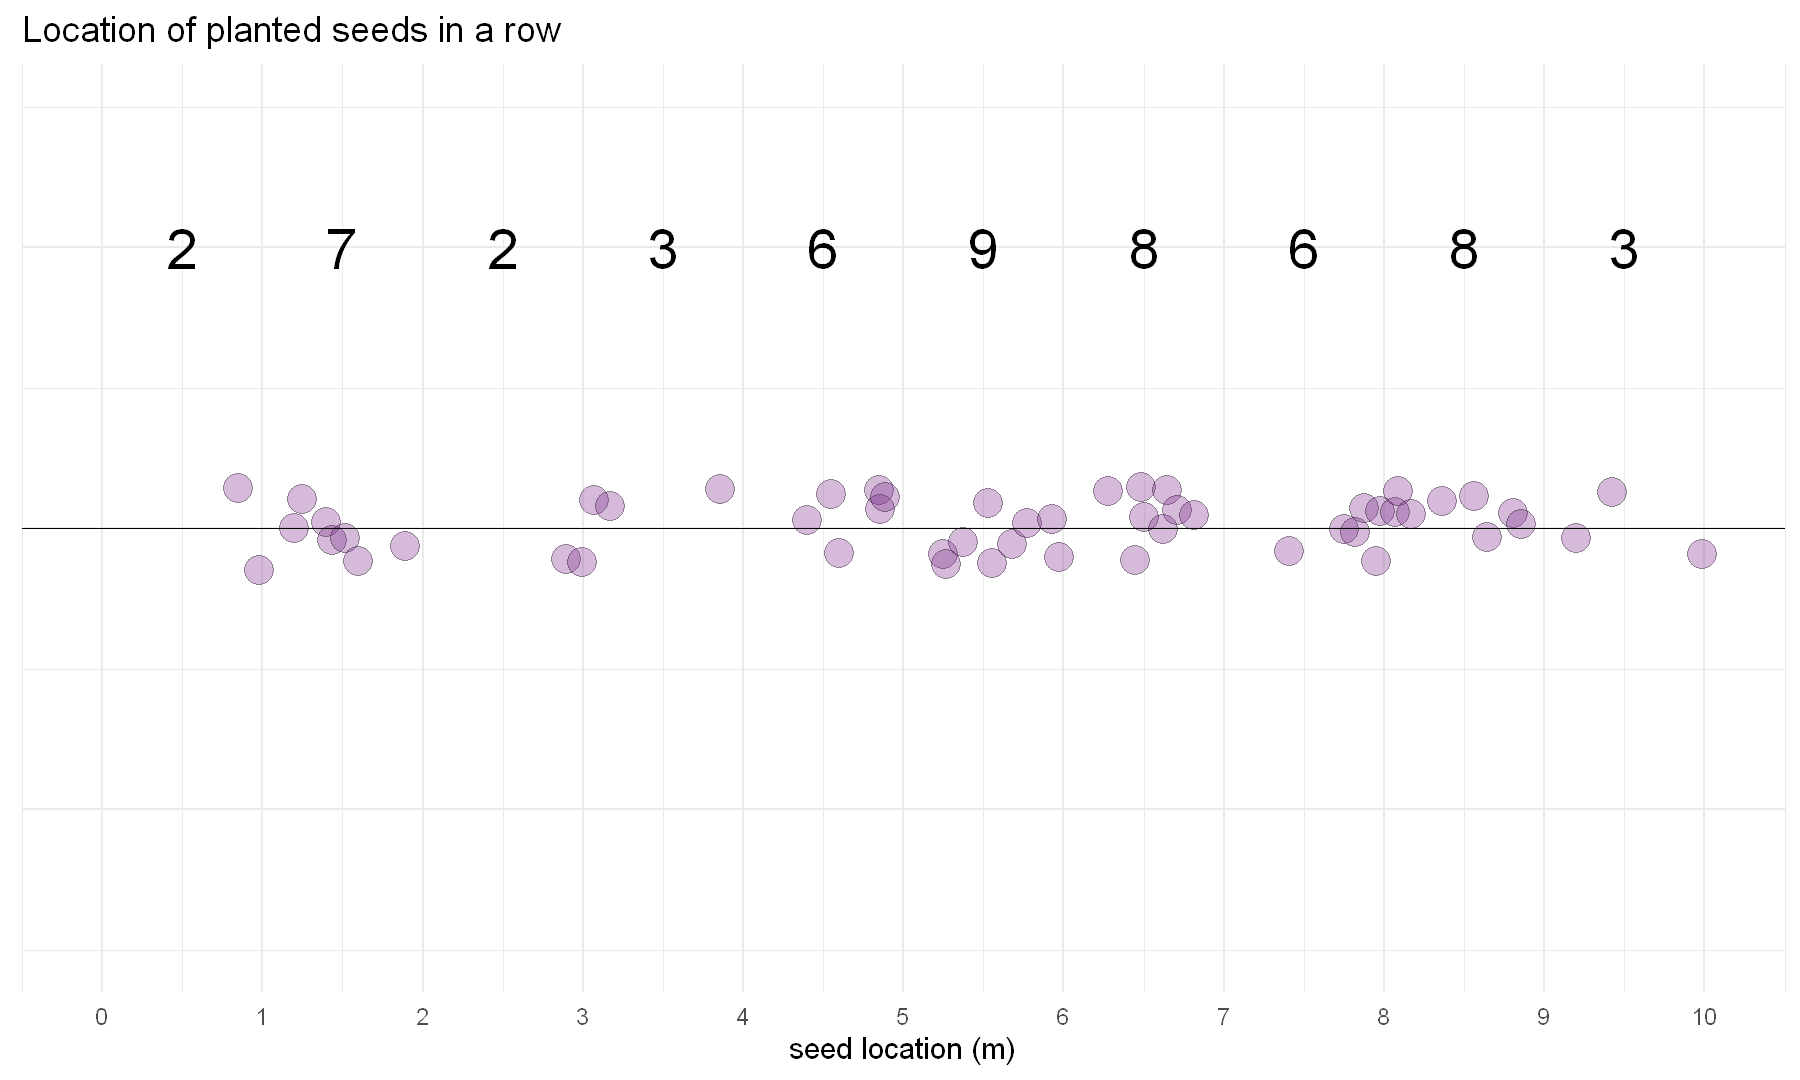

In [5]:
p <- ggplot() +
    # Jittered points for planting locations
    geom_jitter(
        data = planting_df, 
        aes(x = planting_locations, y = 1), 
        width = 0, height = 0.03, 
        fill = "#7E318D", size = 8, shape = 21, alpha = 0.33
    ) +
    
    # Text labels for counts per meter
    geom_text(
        data = counts_per_meter, 
        aes(x = midpoint, y = 1.2, label = n), 
        size = 12
    ) + 
    
    # Axes and scales
    coord_cartesian(xlim = c(0, row_length), ylim = c(0.7, 1.3)) +
    scale_x_continuous(breaks = 0:row_length) +
    
    # Reference line
    geom_hline(yintercept = 1) +
    
    # Labels and titles
    xlab("seed location (m)") + 
    ggtitle("Location of planted seeds in a row") +
    
    # Theme adjustments
    theme(
        axis.text.y = element_blank(),
        axis.title.y = element_blank()
    )

p

> 📝 **Observations**:
> * The number of seeds planted within each meter interval on the $x$-axis is **not** constant.

What we have here is a sample from a **Poisson point process**!

---

# 📏 Poisson Point Process

The Poisson point process is a mathematical model that describes events that occur randomly in some space of interest. In the example explored so far, this space is the positive real line. To visualise the Poisson point process it must be instantiated in some region of this space that is meaningful to the phenomena we want it to describe. We cannot plot the positive real line all the way to infinity!

Let's gather more samples from the Poisson point process. Continuing with the seed example, a field will have multiple rows, each of which will also need to be planted.

> ⭐ **Key Point:**
> * Recall that each **row** is a sample from a Poisson point process.

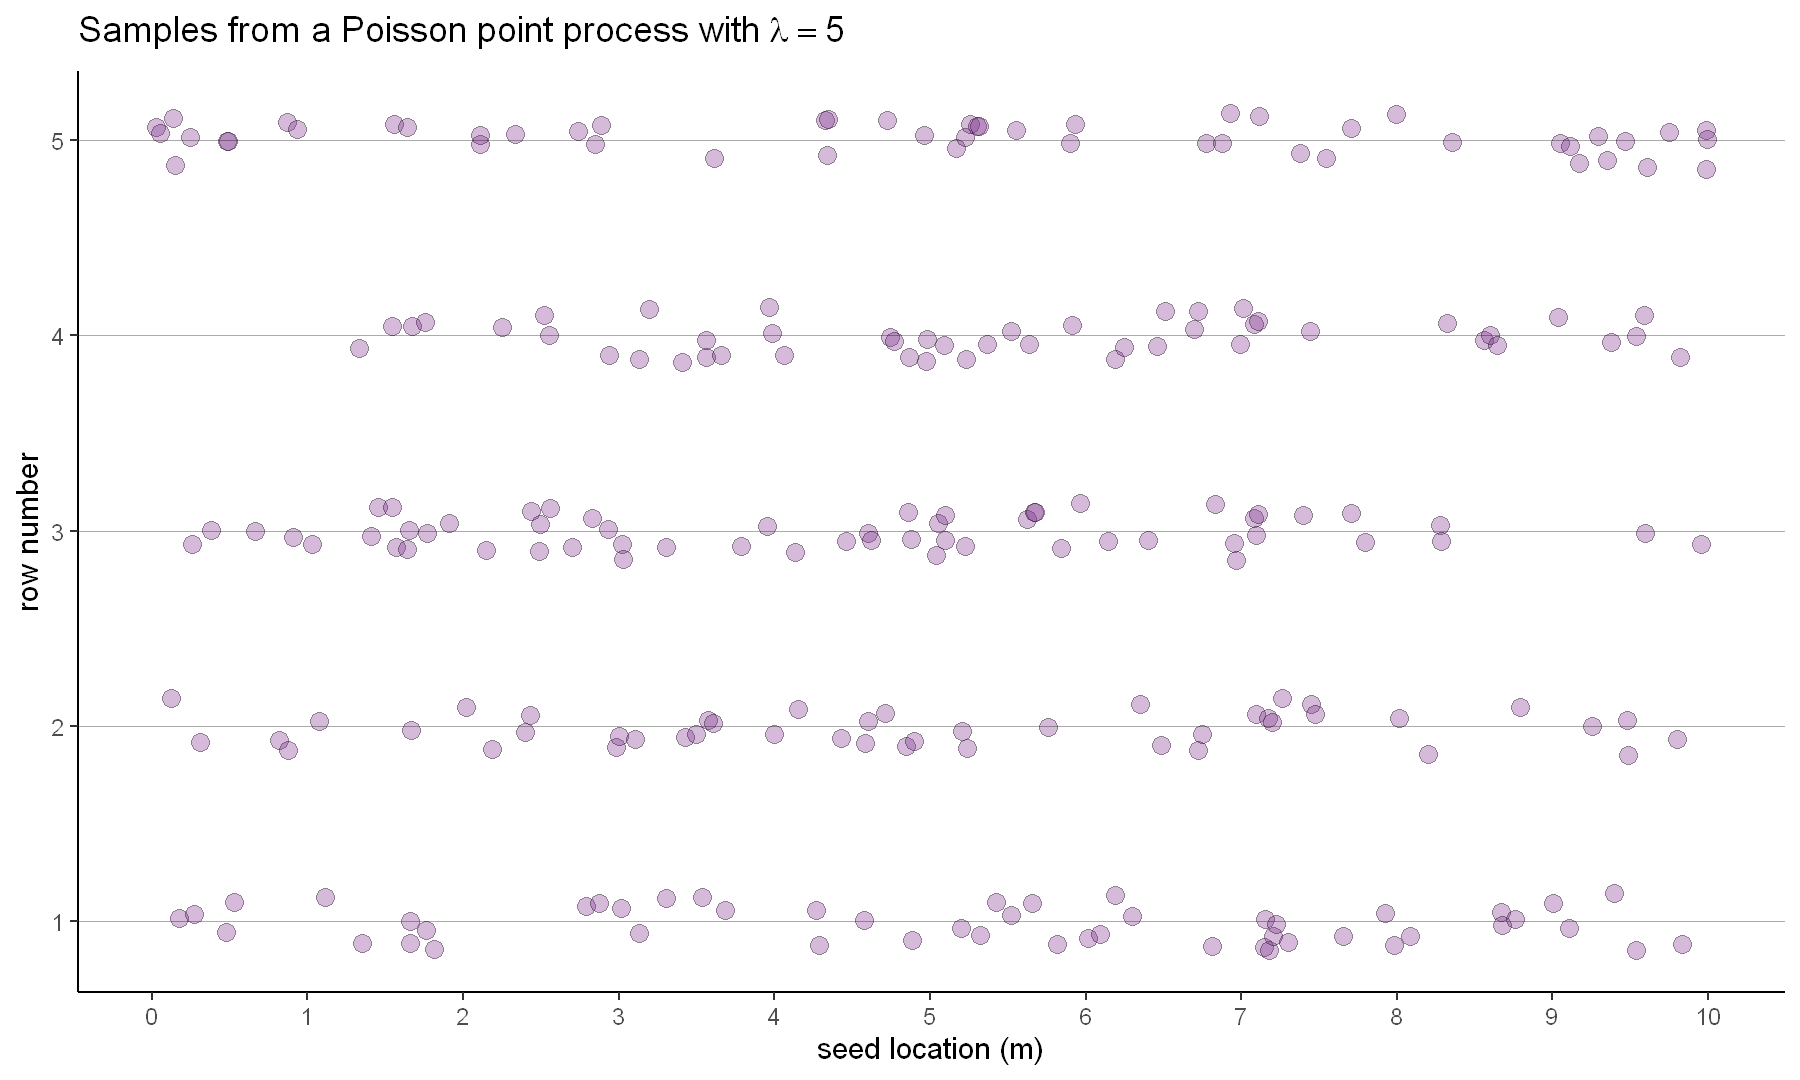

In [35]:
# sample the cumulative sum of values from an exponential distribution with rate lambda
planting_df <- map(1:sample_n, ~ tibble(planting_locations = cumsum(rexp(row_length * seeds_per_meter * 2, rate = seeds_per_meter)), row = .x))
planting_df <- list_rbind(planting_df)

# Number of rows in our field
N_rows <- 20

# Plot "N_rows" draws from the Poisson point process
p <- ggplot(data = planting_df %>%
        filter(
            row <= N_rows,
            planting_locations <= row_length
        )) +

    # Jittered points for planting locations
    geom_jitter(
        aes(x=planting_locations, y=row),
        width = 0, height = 0.15,
        fill="#7E318D", size=5, shape=21, alpha=0.33
    ) +

    # Reference lines
    geom_hline(aes(yintercept = row), alpha=0.33) +

    # Axes and scales
    scale_y_continuous(breaks = 1:N_rows) +
    scale_x_continuous(breaks = c(0:row_length)) +

    # Labels and titles
    xlab("seed location (m)") + ylab("row number") +
    ggtitle(
        bquote("Samples from a Poisson point process with" ~ lambda == .(seeds_per_meter))
    )
p
ggsave(filename = "test.png", dpi = 125, units = "px", width = 1920, height = 1080)

> 📝 **Observations**:
> 1. Over many samples the distribution of planting locations appears uniform.
> 2. There are **no** obvious dependencies between seed locations.
>    * locations *can* be bunched up
>    * locations *can* be spread out

---

## Locations are Uniformly Distributed

Empirically we can show that the distribution of seed locations given the interval and a number of seeds within is uniformly distributed.

> ⭐ **Key Point**:
> * The tolerance for variability in a histogram of uniform samples can be described by quantiles of the **Binomial distribution**.

In [7]:
uniform_df <- planting_df %>%
    filter(between(planting_locations,0,1)) %>%
    add_count(row, name = "n") %>%
    filter(n==4)

N_bins <- 100
breaks <- seq(0,1,length.out = N_bins)

# What values of the binomial distribution contain 99% of the total probability
q <- qbinom(p = c(0.005,0.995), size = nrow(uniform_df) , prob = 1/N_bins)

### 📊 Distribution of Seed Locations

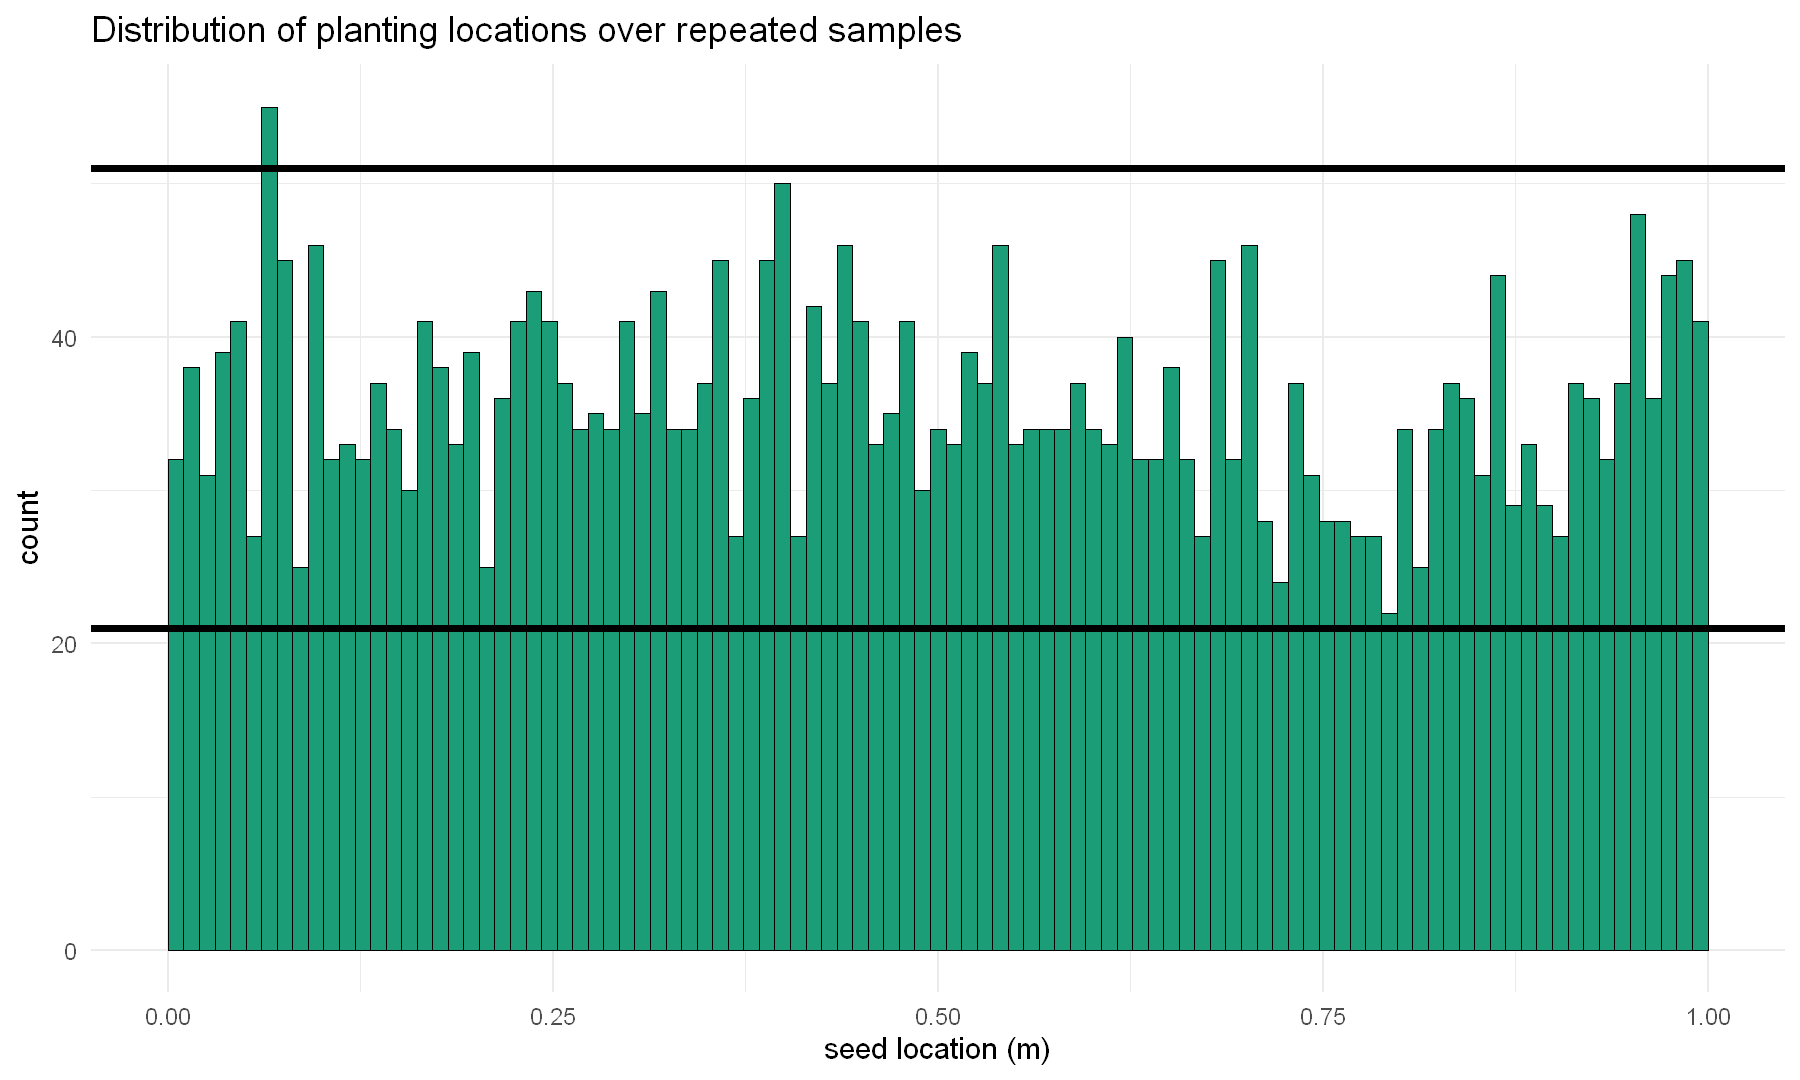

In [8]:
p <- ggplot(uniform_df) +

    # Histogram planting locations
    geom_histogram(
        aes(x=planting_locations),
        breaks=breaks, col="black", fill="#1b9e77") +

    # Reference lines for permissable variance
    geom_hline(yintercept = q, linewidth=2) +

    # Labels and titles
    xlab("seed location (m)") +
    ggtitle("Distribution of planting locations over repeated samples")
p

> 📝 **Observations**:
> * The distribution of seed locations matches what would be expected if they were instead sampled from a uniform ditribution
> * Out of 100 bins we expect **one** bin to fall above or below the solid black lines

---

## 🔍 Poisson Distribution

The number of seeds in any interval $(a, b]$ follows a Poisson distribution with probability mass function,
\begin{equation}
    P(N_{(a, b]} = n) = \frac{(\lambda[b-a])^{n} \exp{(-\lambda[b-a])}}{n!}
\end{equation}
where $n! = n \times (n-1) \times \dots \times 1$ is the *factorial* function, and $\exp{(x)} \approx 2.718^{x}$ is the *exponential* function.

In plain language $P(N_{(a, b]} = n)$ asks the question:
> *"What is the probability that the number of seeds planted in the interval $N_{(a, b]}$, is equal to $n$?"*

The parameters of this distribution are summarised in the table below.

| Parameter   | Interpretation                                   | Constraint                |
|------------|-------------------------------------------------|---------------------------|
| $\lambda$  | Average number of events per unit of measurement | $\lambda > 0$             |
| $n$        | Number of events                                 | $n \in \{0, 1, 2, \dots\}$ |
| $(a, b)$   | Lower and upper bounds of the interval          | Valid real numbers        |

> Let's use the samples from the Poisson point process in `planting_df` to visualise the Poisson distribution.

In [9]:
a <- 0; b <- 2 # pick an interval, make sure a < b!

poisson_df <- planting_df %>%
    filter(between(planting_locations, a, b)) %>%
    count(row, name = "n") %>%
    count(n,   name = "freq") %>%
    mutate(
        estimated = freq / sum(freq),
        theoretical = dpois(n, lambda = seeds_per_meter * (b - a))
    ) %>%
    pivot_longer(cols = c(estimated, theoretical), names_to = "distribution", values_to = "probability") %>%
    select(-freq)


## 📊 Visualising the Poisson Distribution

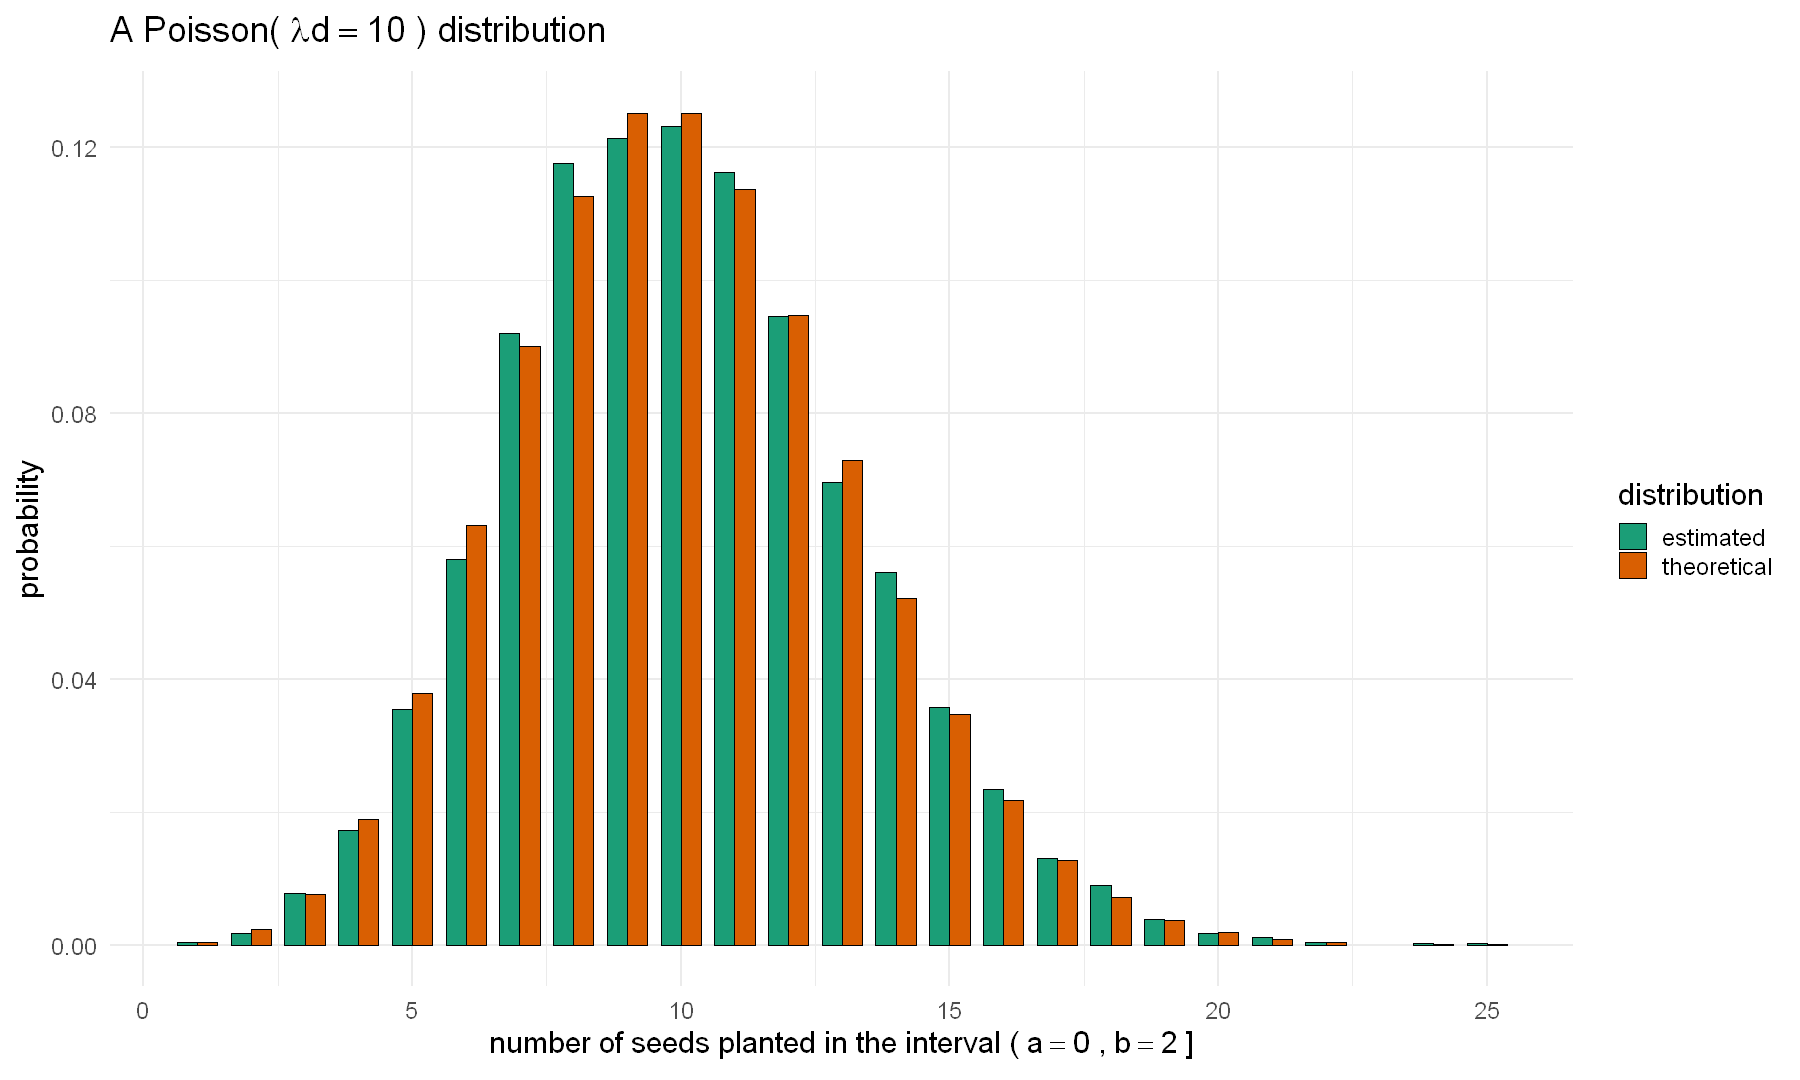

In [10]:
p <- ggplot(data = poisson_df,
            aes(x=n, y=probability, fill=distribution)
           ) + 

    # The probability mass function
    geom_col(col="black", position = position_dodge(width = 0.75), width =0.75) +

    # Colour palettes
    scale_fill_brewer(palette = "Dark2") +

    # Title and labels
    xlab(bquote("number of seeds planted in the interval ("~a == .(a) ~ "," ~b == .(b) ~"]")) + ylab("probability") +
    ggtitle(bquote("A Poisson("~ lambda*d == .(seeds_per_meter * (b-a)) ~") distribution"))
p

> 📝 **Observations**:
> 1. The distribution of seed counts in an interval follows a Poisson distribution

--- 


# 🔍 Why did this Work? 

Well, consider the location of the first event $D_1$. What is the probability that this is less than or equal to some distance $d$. In other words, what is the probability that the first seed is planted in the interval $(0, d]$.
\begin{equation}
    F_{D_1}(d) = P(D_1 \le d)
\end{equation}
where $D_1$ is the random variable and $d$ is a scalar value. If we assume that seed plantings follow a Poisson point process, then we should be able to use the information that the number of seeds in an interval is a Poisson distributed random variable. The Poisson distribution cannot be used to describe $P(D_1 \le d)$ directly because this is a distribution of distances, not counts. However, with a simple manipulation the calculation is much more straightforward,
\begin{equation}
    P(D_1 \le d) = 1 - P(D_1 > d)
\end{equation}
now we have the probability that the location of the first event $D_1$ does not lie in the interval $(0, d]$ this is simply the probability of no events and given our assumptions is described by a Poisson distribution.
\begin{align}
    1 - P(D_1 > d) &= 1 - P(N_{(0, d]} = 0)\\
                   &= 1 - \exp{(-\lambda d)}
\end{align}
The result is exactly the CDF of the exponential distribution with rate $\lambda$. With some more work, it can be shown that this idea holds for all distances $D_i$ between seeds. The key point below covers the intuition why this is the case.

> ⭐ **Key Point**:
> * The Poisson PMF is the same for all intervals $(a_i, b_i]$ where $b_i - a_i = d$

This means that it is the *size* of the interval that matters, not the particular location of the boundaries. The probability distribution of the next distance does not change when it is conditioned on the previous one.

---

# 📌 Summary

✅ **Covered**
> Given a sequence of events generated according to a Poisson point process:
1. The distribution of the number of events in an interval follows a Poisson distribution.
2. The number of points in any two non-overlapping intervals are independent Poisson random variables.
3. Given the number of events and an interval size, the distribution of the *location* of events is uniform.

❌ **Not covered**
1. Poisson process where the underlying space is not one-dimensional.
2. Only the *homogeneous* case where the rate does not depend on specific values of the underlying space is considered.

---
| Key | interpretation                                   |
|-----|--------------------------------------------------|
| ⭐  | Key information | 
| 📝  | Observations    | 
| 📊  | A `ggplot` code cell | 
| 🔍  | Analysis             |
| ⚡  | Bonus content |

# ⚡ Sums of Spaces Between Seeds

The sum of Exponential distributed random variables with the same fixed rate follows a Gamma distribution.
\begin{equation}
    D_n \sim \text{Gamma}(n, \lambda)
\end{equation}

In [11]:
n_planted <- 5 # How many to sum

gamma_df <- planting_df %>%
    group_by(row) %>%
    arrange(planting_locations) %>%
    slice_head(n=n_planted) %>%
    summarise(x=sum(diff(c(0, planting_locations)))) # Append zero to front so that first seed location is also calculated

## 📊 Gamma Distribution

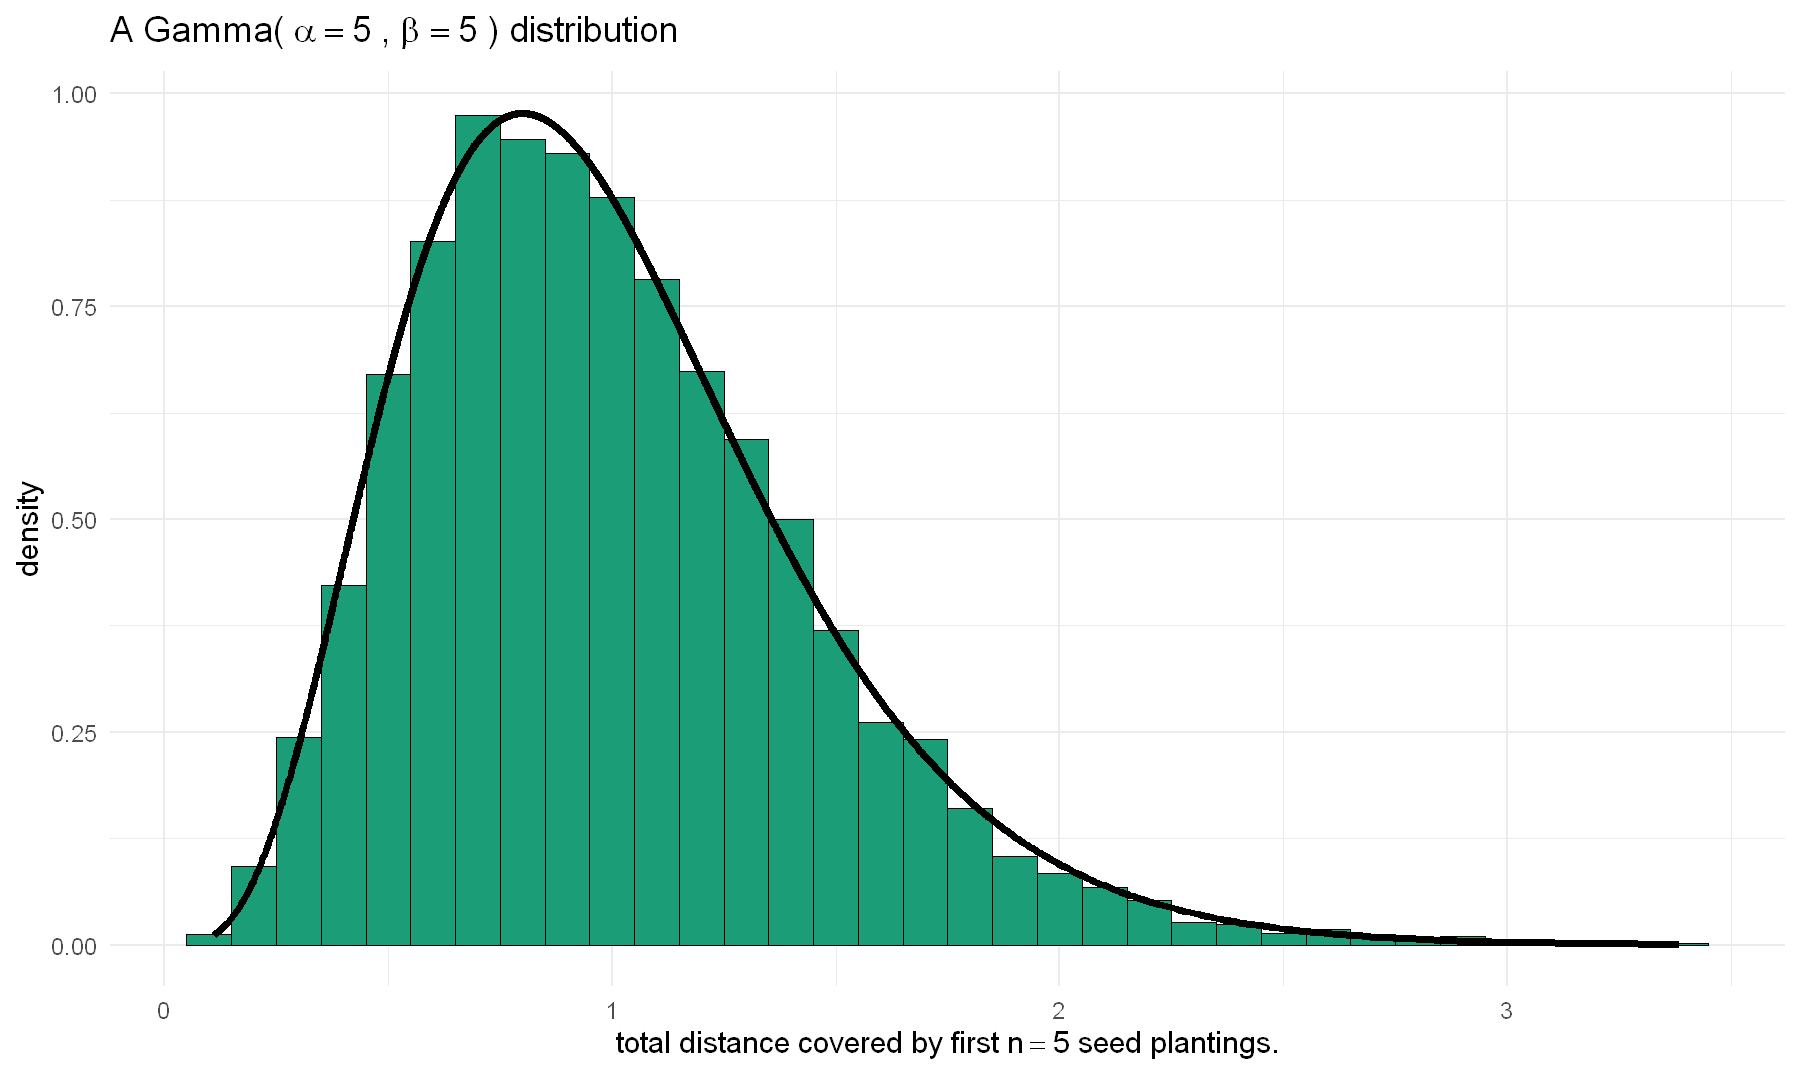

In [12]:
p <- ggplot(gamma_df) +

    # Histogram the sums of the differences
    geom_histogram(
        aes(x=x, y=after_stat(density)),
        binwidth = 0.1, col="black", fill="#1b9e77") +

    # Plot the density function of the Gamma distribution
    geom_line(data=gamma_df %>% 
                  mutate(dgamma = dgamma(x = x, shape = n_planted, rate = seeds_per_meter)),
              aes(x=x, y=dgamma),
              linewidth=2) +

    # Title and labels
    xlab(bquote("total distance covered by first" ~ n == .(n_planted) ~ "seed plantings.")) +
    ggtitle(bquote("A Gamma("~ alpha == .(n_planted) ~ "," ~ beta == .(seeds_per_meter)~") distribution"))
p

# ❓ Question

Assume that the planting of seeds in a row follows a Poisson point process and the expected number of seeds per meter is equal to five:
 1. What is the probability of eight seeds being planted in a two meter interval?
 2. What is the probability of more than ten seeds being planted in a two meter interval?

> ⭐ **Key Points**:
> 1. Events follow a Poisson point process so the number of seeds in an interval is a Poisson distributed random variable.
> 1. When $b-a = 1$, then $\lambda [b-a] = 5$



In [13]:
lambda <- 5; d <- 2

In [14]:
# To answer question one we apply we require the value of the Poisson PMF evaulated at n=8 given lambda=10.
Q1_ans <- dpois(x = 8, lambda = lambda * d)
sprintf("The probability of eight seeds being planted in a two meter interval is: %.2f.", Q1_ans)

[1] "The probability of eight seeds being planted in a two meter interval is: 0.11."

In [15]:
# To answer question two we add up all the probabilities where n>10 given lambda=10 using the CDF of the Poisson distribution
prob_leq_ten <- ppois(q = 10, lambda = lambda * d)
prob_gr_ten <- 1- prob_leq_ten
sprintf("The probability of more than ten seeds planted in a two meter interval is: %.2f.", prob_gr_ten)

[1] "The probability of more than ten seeds planted in a two meter interval is: 0.42."